## Objetivos

aaaa

## Introducción

aaaa

## Carga de librerias y dataset

Las librerias necesarias para este notebook serán las siguientes importadas:

In [1]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"""""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [51]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


FileNotFoundError: [Errno 2] No such file or directory: '/datasets/fiufip_dataset.csv'

In [52]:
df = pd.read_csv("fiufip_dataset.csv")

Se renombra a las columnas en un formato mas comodo de manejar.

# Aplicando Ingeniería de Features

## Verificando la "calidad" de los datos


### Chequeo de valores NULOS

Las posibles representaciones de valores nulos ingresados tales como '-', '?', ' ', etc se las reemplaza por el valor nulo NaN en caso de existir dichos valores representativos del nulo en las columnas tanto numericas como no numericas.

In [4]:
cantidad_NaN_agregados = 0
for una_columna in df.columns:
    if df[una_columna].astype(str).str.contains("[^A-Za-z0-9]+$").any():
         df[una_columna].replace(to_replace="[^A-Za-z0-9]+$", value=np.nan, regex=True, inplace=True)
         cantidad_NaN_agregados=cantidad_NaN_agregados+1    
print(f'Cantidad columnas modificadas agregando NaN por representación incorrecta del mismo: {cantidad_NaN_agregados}')

Cantidad columnas modificadas agregando NaN por representación incorrecta del mismo: 0


#### Chequeo en variables numericas

Tambien habria revisar los features numericos con valores negativos


In [5]:
print(f'-> Cantidad de columnas numéricas: {df.describe().columns.size}')
df.describe().columns

-> Cantidad de columnas numéricas: 5


Index(['anios_estudiados', 'edad',
       'ganancia_perdida_declarada_bolsa_argentina',
       'horas_trabajo_registradas', 'tiene_alto_valor_adquisitivo'],
      dtype='object')

La unica que tendria sentido no modificar es la _'ganancia_perdida_declarada_bolsa_argentina'_ ya que puede admitir valores negativos. Las demas que contengan un negativo se las considera como **NaN**.


In [6]:
columnas_con_numeros = ['anios_estudiados', 'edad', 'tiene_alto_valor_adquisitivo']
(df[columnas_con_numeros] < 0).any()

anios_estudiados                False
edad                            False
tiene_alto_valor_adquisitivo    False
dtype: bool

Lo cual observamos que no hay valores incorrectos en dichas columnas.


## PROBANDO COSAS: Cantidad categoricas unicas por features. 
Ejemplo 'genero', solo figuran 2 categorias: F y M.

anios = df.anios_estudiados.value_counts(dropna=False)
print(f'Hay un total de {len(anios)}')
display(anios)
print('')

barrios = df.barrio.value_counts(dropna=False)
print(f'Hay un total de {len(barrios)}')
display(barrios)
print('')

edades = df.edad.value_counts(dropna=False)
print(f'Hay un total de {len(edades)}')
display(edades)
print('')

cat = df.categoria_de_trabajo.value_counts(dropna=False)
print(f'Hay un total de {len(cat)}')
display(cat)
print('')

educacion = df.educacion_alcanzada.value_counts(dropna=False)
print(f'Hay un total de {len(educacion)}')
display(educacion)
print('')

estadomarital = df.estado_marital.value_counts(dropna=False)
print(f'Hay un total de {len(estadomarital)}')
display(estadomarital)
print('')

gananPerd = df.ganancia_perdida_declarada_bolsa_argentina.value_counts(dropna=False)
print(f'Hay un total de {len(gananPerd)}')
display(gananPerd)
print('')

gen = df.genero.value_counts(dropna=False)
print(f'Hay un total de {len(gen)}')
display(gen)
print('')

horus = df.horas_trabajo_registradas.value_counts(dropna=False)
print(f'Hay un total de {len(horus)}')
display(horus)
print('')

rel = df.religion.value_counts(dropna=False)
print(f'Hay un total de {len(rel)}')
display(rel)
print('')

rolFamili = df.rol_familiar_registrado.value_counts(dropna=False)
print(f'Hay un total de {len(rolFamili)}')
display(rolFamili)
print('')

valorADaLTO = df.tiene_alto_valor_adquisitivo.value_counts(dropna=False)
print(f'Hay un total de {len(valorADaLTO)}')
display(valorADaLTO)
print('')

JOB = df.trabajo.value_counts(dropna=False)
print(f'Hay un total de {len(JOB)}')
display(JOB)
print('')

## Chequeo de cada feature individualmente


### Feature: rol_familiar_registrado

Algo que nos parecio raro al analizar cada valor de los features, es que especialmente el de *rol_familiar_registrado* tiene dos posibles valores iguales pero se tiene un dato de *casado* siendo *mujer*, como tambien *casada* siendo *hombre*

In [7]:
hombre_casada = (df.rol_familiar_registrado == 'casada') & (df.genero == 'hombre')
mujer_casado = (df.rol_familiar_registrado == 'casado') & (df.genero == 'mujer')
df[mujer_casado | hombre_casada]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
575,17,Palermo,relacion_de_dependencia,29,universidad_3_anio,matrimonio_civil,0,hombre,40,cristianismo,casada,1,directivo_gerente
7109,13,Palermo,relacion_de_dependencia,34,4_anio,matrimonio_civil,0,mujer,40,cristianismo,casado,0,ventas
27141,17,NaN,relacion_de_dependencia,36,universidad_3_anio,matrimonio_civil,0,hombre,60,cristianismo,casada,0,ventas


El cual puede que a la hora de la insercidf[mujer_casado | hombre_casada]ón de los datos no haya sido lo suficientemente inclusiva.
Cambiaremos el genero a ambos segun corresponda.

In [8]:
df['genero'].mask(hombre_casada, 'mujer', inplace=True)
df['genero'].mask(mujer_casado, 'hombre', inplace=True)

Refrescamos las variables booleanas y comprobamos que se haya reemplazado

In [9]:
hombre_casada = (df.rol_familiar_registrado == 'casada') & (df.genero == 'hombre')
mujer_casado = (df.rol_familiar_registrado == 'casado') & (df.genero == 'mujer')
df[mujer_casado | hombre_casada]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo


#### **PARA DEBATIR CON EL COMPAÑEROO**

In [11]:
rolFamili = df.rol_familiar_registrado.value_counts(dropna=False)
print(f'Hay un total de {len(rolFamili)}')
display(rolFamili)
print('')

Hay un total de 6


casado         13193
sin_familia     8305
con_hijos       5068
soltero_a       3446
casada          1568
otro             981
Name: rol_familiar_registrado, dtype: int64

Aca veo que hay rol de *soltero_a*, el cual no diferencia de mujeres y hombres pero si le pedis que los diferencie solo mandas el comando!

In [12]:
df[df.rol_familiar_registrado == 'soltero_a'].genero.value_counts(dropna=False)

mujer     2654
hombre     792
Name: genero, dtype: int64

No se si eso podria ser interesante de analizar... Pero podrias saber la cantidad de mujeres que le corresponde, muy facilmente.

Y si miro la tabla de nuevo, tenes *casada* y *casado*. 

No seria mejor unir en *casada_o* ¿?

Despues, si queres diferenciar cuales son hombres y mujeres de ese rol, simplemente te fijas su genero.

In [13]:
casada_mujer_o_casado_hombre = (df.rol_familiar_registrado == 'casado' ) | (df.rol_familiar_registrado == 'casada') 
df['rol_familiar_registrado'].mask(casada_mujer_o_casado_hombre, 'casado_a', inplace=True)

Si vuelvo a analizar.. Prescindimos de un rol y lo unimos

In [14]:
rolFamili = df.rol_familiar_registrado.value_counts(dropna=False)
print(f'Hay un total de {len(rolFamili)}')
display(rolFamili)
print('')

Hay un total de 5


casado_a       14761
sin_familia     8305
con_hijos       5068
soltero_a       3446
otro             981
Name: rol_familiar_registrado, dtype: int64

Si queres saber la informacion de si es hombre o mujer, tal como nos decia la tabla, simplemente le impogno esa condicion

In [15]:
df[df.rol_familiar_registrado == 'casado_a'].genero.value_counts(dropna=False)

hombre    13193
mujer      1568
Name: genero, dtype: int64

El cual coincide con la informacion que nos decia antes la tabla separadamente de *casada* y *casado*. 

En conclusion se puede recudir la cardinalidad un 16%. 

^ **INVESIGAR A VER SI ESTA BIEN DICHO ESA FRASE** ^

### Feature: *estado_marital*

In [16]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado_a,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado_a,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casado_a,0,profesional_especializado


Cambiamos nombre de 3 tipos del feature *estado_marital*

In [17]:
divorciado = df.estado_marital == 'divorciado' 
separado = df.estado_marital == 'separado'
df['estado_marital'].mask(divorciado, 'divorciado_a', inplace=True)
df['estado_marital'].mask(separado, 'separado_a', inplace=True)

df.estado_marital.value_counts(dropna=False)

df.rol_familiar_registrado.value_counts(dropna=False)

df.genero.value_counts(dropna=False)

display(df[(df.estado_marital == 'matrimonio_civil')].rol_familiar_registrado.value_counts(dropna=False), '')
display(df[(df.estado_marital == 'sin_matrimonio')].rol_familiar_registrado.value_counts(dropna=False), '')
display(df[(df.estado_marital == 'divorciado_a')].rol_familiar_registrado.value_counts(dropna=False), '')
display(df[(df.estado_marital == 'separado_a')].rol_familiar_registrado.value_counts(dropna=False), '')
display(df[(df.estado_marital == 'viudo_a')].rol_familiar_registrado.value_counts(dropna=False), '')
display(df[(df.estado_marital == 'pareja_no_presente')].rol_familiar_registrado.value_counts(dropna=False), '')
display(df[(df.estado_marital == 'matrimonio_militar')].rol_familiar_registrado.value_counts(dropna=False), '')

# Conversion de Variables

## Conversion de variables categoricas

### Categóricas de baja cardinalidad

In [18]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado_a,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado_a,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado_a,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casado_a,0,profesional_especializado


CONVERSION BAJA CARDINALIDAD EN CATEGORICAS.

Tirandole un Ordinal Encoder (Label Encoder idem).. en vez de ver Strings en "estado_marital", ves numeros en cada string que haya!
Y luego, el modelo ML laburara mejor asi, y tmb tenes funcion inversa que podes ver que le correspondia a ese numero. 

Tambien tenias el One Hot Encoding. Crea una columna binaria por cada valor de la variable... O sea, tenes 3 colores de ojos en una columna, entonces, tendrias 3 columnas, pero como regla general para evitar problema colinealidad es suficiente con 'n-1' columnas, o sea, 2 columnas.
En esa columna representas 1s y 0s.

-----
En esta parte, yo veo que a todas de baja cardinalidad podrias aplicar alguna de estos 2 metodos. Pero eso sirivria mas en la 2° parte del TP cuando hagamos ML y necesite numeros posta y NO strings como ahora (ejemplo, genero: mujer y hombre.. eso a futuro para el ML lo ponemos como 1 y 0 asi labura m ejor el ML)

Pero que se yo.. ¿que hacemos? Dejamos asi y listo? Ojo quizas estoy entendiendo mal esas cosas...



-----
Tambien esto es para las categoricas, no representntan una nocion de orden!



### Categóricas de alta cardinalidad

In [19]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado_a,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado_a,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado_a,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casado_a,0,profesional_especializado


#### Feature: *estado_marital*

Aca yo veo el claro ejemplo de los Barrios.

In [20]:
 barrios = df.barrio.value_counts(dropna=False, normalize=True) * 100
print(f'Hay un total de {len(barrios)}') 
display(barrios)
print('')

Hay un total de 42


Palermo                89.585701
Belgrano                1.974755
NaN                     1.790486
San Isidro              0.608089
Villa Urquiza           0.420749
Recoleta                0.371610
La Boca                 0.350112
Agronomia               0.325543
Almagro                 0.307116
Balvanera               0.291760
Puerto Madero           0.276404
Caballito               0.248764
Boedo                   0.245693
Barracas                0.230337
Chacarita               0.224195
Coghland                0.214981
Floresta                0.205768
Constitucion            0.196554
Colegiales              0.190412
Flores                  0.184270
Liniers                 0.181198
Monte Castro            0.156629
Mataderos               0.135131
Nueva Pompeya           0.132060
Monserrat               0.113633
nuñez                   0.104419
Parque Chacabuco        0.095206
Parque Avellaneda       0.089064
Villa Luro              0.089064
Parque Chas             0.085992
La Paterna

42 barrios, y solo el 89.5% esta en Palermo... altisima Cardinalidad...

Palermo          29170
Belgrano           643
NaN                583
San Isidro         198
Villa Urquiza      137
Recoleta           121
La Boca            114
Agronomia          106
Almagro            100
Balvanera           95
Name: barrio, dtype: int64

[]

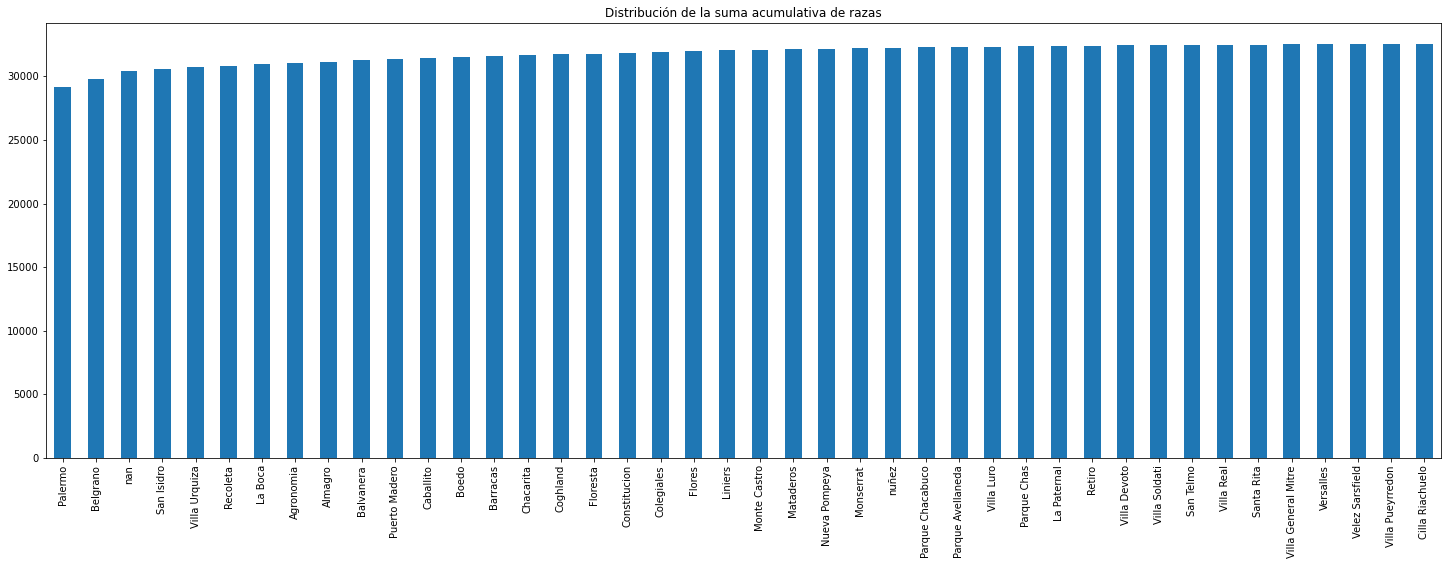

In [21]:
barrios_unicos = df['barrio'].value_counts(dropna=False)
display(barrios_unicos.head(10))
barrios_unicos.cumsum().plot(
    kind='bar', title="Distribución de la suma acumulativa de razas", figsize=(25, 8)
)
plt.plot()

Ahi en el grafico, fijate el primero de 'Palermo' esta al 90% lleno.. podrias quedarte solo con el 95% y reduciria muchisimo la cardinalidad del mismo

In [34]:
df['barrio'].value_counts(dropna=False)

Palermo          29170
Belgrano           643
NaN                583
Otro               338
San Isidro         198
Villa Urquiza      137
Recoleta           121
La Boca            114
Agronomia          106
Almagro            100
Balvanera           95
Puerto Madero       90
Caballito           81
Boedo               80
Barracas            75
Chacarita           73
Coghland            70
Floresta            67
Constitucion        64
Colegiales          62
Flores              60
Liniers             59
Monte Castro        51
Mataderos           44
Nueva Pompeya       43
Monserrat           37
Name: barrio, dtype: int64

In [48]:
barrios = df['barrio'].value_counts(dropna=False)

In [43]:
barris_achicado = barrios[barrios < 35 ].index

In [40]:
df.barrio.replace(to_replace=barris_achicado, value='Otro',   inplace=True )

In [41]:
df.barrio.value_counts(dropna=False,normalize=True) * 100

Palermo          89.585701
Belgrano          1.974755
NaN               1.790486
Otro              1.038052
San Isidro        0.608089
Villa Urquiza     0.420749
Recoleta          0.371610
La Boca           0.350112
Agronomia         0.325543
Almagro           0.307116
Balvanera         0.291760
Puerto Madero     0.276404
Caballito         0.248764
Boedo             0.245693
Barracas          0.230337
Chacarita         0.224195
Coghland          0.214981
Floresta          0.205768
Constitucion      0.196554
Colegiales        0.190412
Flores            0.184270
Liniers           0.181198
Monte Castro      0.156629
Mataderos         0.135131
Nueva Pompeya     0.132060
Monserrat         0.113633
Name: barrio, dtype: float64

O sea.. mamdé un 1.03% a "Otro" lo cual no se si nos covneiene realizar esto ahora que no usamos modelos complejos de ML

Tampoco se si esta bien.. Tenias 100 personas o mas que mande a 'Otro'

Quizas perdi mucha informacion

Con Jorge.. él habia mostrado y borrado solamente pocas personas.. o sea, ponele que eran 10 o 20, y cada  estado del feature lo usaba 1 persona

----
Despues no se que otro Feature analizar segun la baja u alta cardinalidad para hacer una "Conversion" tampoco se si es tan necesario tal como dije por no usar tan complejos ML modelos..

## Conversion de variables Numericas

In [ ]:
df.head()

Tenias varios conceptos para aplicar a Numericos y que figuran en el notebook de 'feature_engineering'

#### Scalers

Es una transformación por la cual escalamos a un determinado rango/distribución.. ponele valores de peso y altura, te interesa que se distribuyan como una distribucion normal por ejemplo... Esto entiendo que no haria falta aplicar aca porque como no usamos modelos ML, tipo..

#### Discretización: Binarizer y KBinsDiscretizer

Esto lo que hace, pasar de Continuo a Discreto

Quizas para la ganancia perdida decalrad de la bolsa..al tener muchos valores,seria continua ahi deberiamos discretizar? 

Ahi deberiamos discretizar?

O no hace falta por no usar ML complejo?

## Conversion variales ordinales

Aca si son variables con un cierto orden... Seria mejor asocialer un numero? 

El 1 representa el nivel mas bjajo de educacion alcanza.. y luego el mas alto seria la educacion mas alta?

Conviene hacer esa conversion?

In [47]:
df.educacion_alcanzada.value_counts()

4_anio                10501
5_anio                 7291
universidad_3_anio     5355
universidad_4_anio     1723
universidad_1_anio     1382
2_anio                 1175
universidad_2_anio     1067
1_anio                  933
7-8_grado               646
universiada_5_anio      576
9_grado                 514
3_anio                  433
universiada_6_anio      413
5-6_grado               333
1-4_grado               168
preescolar               51
Name: educacion_alcanzada, dtype: int64

# Missings (Trabajando con valores faltantes)

In [ ]:
df.isnull().sum()

In [ ]:
(df.isnull().mean() * 100).to_frame('Porcentaje de NaN')

Habia en el notebook de 'feature_engineering' 3 opciones

- **Opcion 1: remover los nulos del dataset**

Literalmente es eliminarlas, no la veo buena opcion, ya que es alto porcentaje de nulos..

- **Opcion 2 - IMPUTERS: completar usando info de esa columna (Univariadas)**


-> *Numericas*
Completando con la media, mediana, etc. Algun estadistico.

-> *Categóricas*
Los encoders lo solucionan... One Hot Encoding.. te asigna columna pa NaN (eso entiendo)


- **Opcion 3 - IMPUTERS: completar usando info de las demas columnas (Multivariada)**

No lo veremos para este TP, es aplicar modelos complejos o algo asi (KNN?)

----

- En la teorica habia dicho convertir los nulos en una categoria mas.. por ejemplo, aca trabajo podria considerar "no responde"

- Y tambien... agregar una columna indicando que fue o no modificada con algun Imputer.. eso ayudaria al modelo de ML.

### Una solucion

Una posible, de tantas, podria ser convertir esas 2 categorias "trabajo" y "categoria_de_trabajo" en "no responde" 

Tambien la parte de "barrio"

Porque si promediamos con la media ahi, es como que podriamos perder potencial informcacion.

Quizas la gente que no responde donde vive, podria ser personas que tienen alto ingreso, y por temor a que lo identifiquen seria mejor ocultarse

Idem razonamiento con el trabajo.. Mira si es un Narco que indicó que gana mucho y prefiere no decirlo?

Por eso preferiria tener que no inferir con IMputers (con algun estadistico) ni mucho menos borraria esas filas, ni columnas!!! 


In [ ]:
df['trabajo'].fillna("No responde",inplace=True)
df['categoria_de_trabajo'].fillna("No responde",inplace=True)
df['barrio'].fillna("No responde",inplace=True)

Chequeo si no hay mas nulos


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad